### D208 Performance Assessment Task 1
##### NBM3 Task1 Linear Regression Modeling
Predictive Modeling - D208
PRFA - NBM3

### Competencies

##### 4030.5.2 : Multiple Regression
The graduate employs multiple regression algorithms with categorical and numerical predictors in describing phenomena.

##### 4030.5.3 : Regression Implications
The graduate makes assertions based on regression modeling.

#### Imports

 * Standard Imports
   * [Pandas](https://pandas.pydata.org/)
   * [NumPy](https://numpy.org/doc/stable/)
 * Visualizations
   * [matplotlib](https://matplotlib.org/stable/index.html)
   * [Seaborn](https://seaborn.pydata.org/)
 * Statistical
   * [Ordinary Least Squares (OLS)](https://www.statsmodels.org/stable/generated/statsmodels.formula.api.ols.html)
   * [RegressionResults](https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.RegressionResults.html)
   * [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.api import OLS
from statsmodels.regression.linear_model import RegressionResults
from sklearn.linear_model import LinearRegression

# Data Preparation C1
## Loading Medical Dataset, Renaming, and Category Type Changes
Loading `medical_clean.csv`
The data for this performance assessments comes pre-cleaned similar to the output result from D207.

  * Check the datatypes
  * Check for null, na, and empty values
  * Rename Items1-8
  * Update chr, str datatypes to 'Category'
  * Removing categorical variables with high cardinality. They can potentially lead to over-fitting models.

In [2]:
original_medical = medical_clean_data = pd.read_csv('./Data/Medical/medical_clean.csv')
#del medical_clean_data[medical_clean_data.columns[0]]

any_missing_values = medical_clean_data.isna().values.any()
if not any_missing_values:
    print('Medical data does NOT contain any missing values\n')
else:
    print('Medical data CONTAINS missing values.\n')

column_renames = {
     'Item1': 'Timely_Admission'
    ,'Item2': 'Timely_Treatment'
    ,'Item3': 'Timely_Visits'
    ,'Item4': 'Reliability'
    ,'Item5': 'Options'
    ,'Item6': 'Hours_Of_Treatment'
    ,'Item7': 'Courteous_Staff'
    ,'Item8': 'Listening' #Evidence of active listening from Doctor
}
medical_clean_data.rename(columns=column_renames, inplace=True)
#medical_clean_data

removal_attributes = ['CaseOrder', 'Customer_id', 'Interaction', 'UID',
                      'Zip', 'Lat', 'Lng', 'City', 'State', 'County',
                      'Area', 'Job', 'Marital', 'Population', 'TimeZone']

medical_clean_data = medical_clean_data.drop(columns=removal_attributes)

category_dtype = 'category'
convert_to_category = {
    'Gender': category_dtype,
    'ReAdmis': category_dtype,
    'Soft_drink': category_dtype,
    'Initial_admin': category_dtype,
    'HighBlood': category_dtype,
    'Stroke': category_dtype,
    'Complication_risk': category_dtype,
    'Overweight': category_dtype,
    'Arthritis': category_dtype,
    'Diabetes': category_dtype,
    'Hyperlipidemia': category_dtype,
    'BackPain': category_dtype,
    'Anxiety': category_dtype,
    'Allergic_rhinitis': category_dtype,
    'Reflux_esophagitis': category_dtype,
    'Asthma': category_dtype,
    'Services': category_dtype,
    'Timely_Admission': category_dtype,
    'Timely_Treatment': category_dtype,
    'Timely_Visits': category_dtype,
    'Reliability': category_dtype,
    'Options': category_dtype,
    'Hours_Of_Treatment': category_dtype,
    'Courteous_Staff': category_dtype,
    'Listening': category_dtype
}

medical_clean_data = medical_clean_data.astype(convert_to_category)

#Logical categorical variables converted to numerical
columns_to_reexpress = ['ReAdmis', 'Soft_drink', 'HighBlood', 'Stroke',
                       'Overweight', 'Arthritis', 'Diabetes', 'Hyperlipidemia',
                       'BackPain', 'Anxiety', 'Allergic_rhinitis', 'Reflux_esophagitis',
                       'Asthma']
for column in columns_to_reexpress:
    medical_clean_data[f'Dummy_{column}'] = medical_clean_data[column].map({'Yes': 1, 'No': 0 }).astype(np.int64)

categorical_medical_data = medical_clean_data[convert_to_category.keys()]
high_cardinalities = categorical_medical_data.nunique() > 3 #(> 3-5 Levels)
high_cardinalities = high_cardinalities[high_cardinalities == True]
high_cardinalities = list(high_cardinalities.index.values)
print('Categoricals with high cardinality to be removed:')
print(high_cardinalities)
print('\n')

medical_clean_data = medical_clean_data.drop(columns=high_cardinalities)

low_cardinalities = [item for item in list(convert_to_category.keys()) if item not in high_cardinalities]
print('Categoricals remaining:')
print(low_cardinalities)
print('\n')

#Re-level ordinal/nominal categoricals
medical_clean_data['Dummy_Complication_risk'] = medical_clean_data['Complication_risk'].map({'Low': 0, 'Medium': 1, 'High': 2}).astype(np.int64)
medical_clean_data['Dummy_Initial_admin'] = medical_clean_data['Initial_admin'].map({'Emergency Admission': 0, 'Elective Admission': 1, 'Observation Admission': 2}).astype(np.int64)
medical_clean_data['Dummy_Gender'] = medical_clean_data['Gender'].map({'Male': 0, 'Female' : 1, 'Nonbinary': 2}).astype(np.int64)

prepared_medical_data = medical_clean_data.drop(columns=medical_clean_data.select_dtypes(include=category_dtype))

Medical data does NOT contain any missing values

Categoricals with high cardinality to be removed:
['Services', 'Timely_Admission', 'Timely_Treatment', 'Timely_Visits', 'Reliability', 'Options', 'Hours_Of_Treatment', 'Courteous_Staff', 'Listening']


Categoricals remaining:
['Gender', 'ReAdmis', 'Soft_drink', 'Initial_admin', 'HighBlood', 'Stroke', 'Complication_risk', 'Overweight', 'Arthritis', 'Diabetes', 'Hyperlipidemia', 'BackPain', 'Anxiety', 'Allergic_rhinitis', 'Reflux_esophagitis', 'Asthma']




## Data Preparation C2

#### Summary Statistics

In [10]:
#Summary Statistics
prepared_medical_data.describe(include='all')


,Children,Age,Income,VitD_levels,Doc_visits,Full_meals_eaten,vitD_supp,Initial_days,TotalCharge,Additional_charges,...,Dummy_Diabetes,Dummy_Hyperlipidemia,Dummy_BackPain,Dummy_Anxiety,Dummy_Allergic_rhinitis,Dummy_Reflux_esophagitis,Dummy_Asthma,Dummy_Complication_risk,Dummy_Initial_admin,Dummy_Gender
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,2.097200,53.511700,40490.495160,17.964262,5.012200,1.001400,0.398900,34.455299,5312.172769,12934.528587,...,0.27380,0.337200,0.411400,0.321500,0.394100,0.413500,0.28930,1.123300,0.737600,0.544600
std,2.163659,20.638538,28521.153293,2.017231,1.045734,1.008117,0.628505,26.309341,2180.393838,6542.601544,...,0.44593,0.472777,0.492112,0.467076,0.488681,0.492486,0.45346,0.730172,0.825115,0.539296
min,0.000000,18.000000,154.080000,9.806483,1.000000,0.000000,0.000000,1.001981,1938.312067,3125.703000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,0.000000,36.000000,19598.775000,16.626439,4.000000,0.000000,0.000000,7.896215,3179.374015,7986.487755,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000,0.000000
50%,1.000000,53.000000,33768.420000,17.951122,5.000000,1.000000,0.000000,35.836244,5213.952000,11573.977735,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000,1.000000
75%,3.000000,71.000000,54296.402500,19.347963,6.000000,2.000000,1.000000,61.161020,7459.699750,15626.490000,...,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,2.000000,1.000000,1.000000
max,10.000000,89.000000,207249.100000,26.394449,9.000000,7.000000,5.000000,71.981490,9180.728000,30566.070000,...,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,2.000000,2.000000,2.000000


## Data Preparation C3

#### Generate Univariate and Bivariate Visualizations of distributions

Univariate Numerical Variables


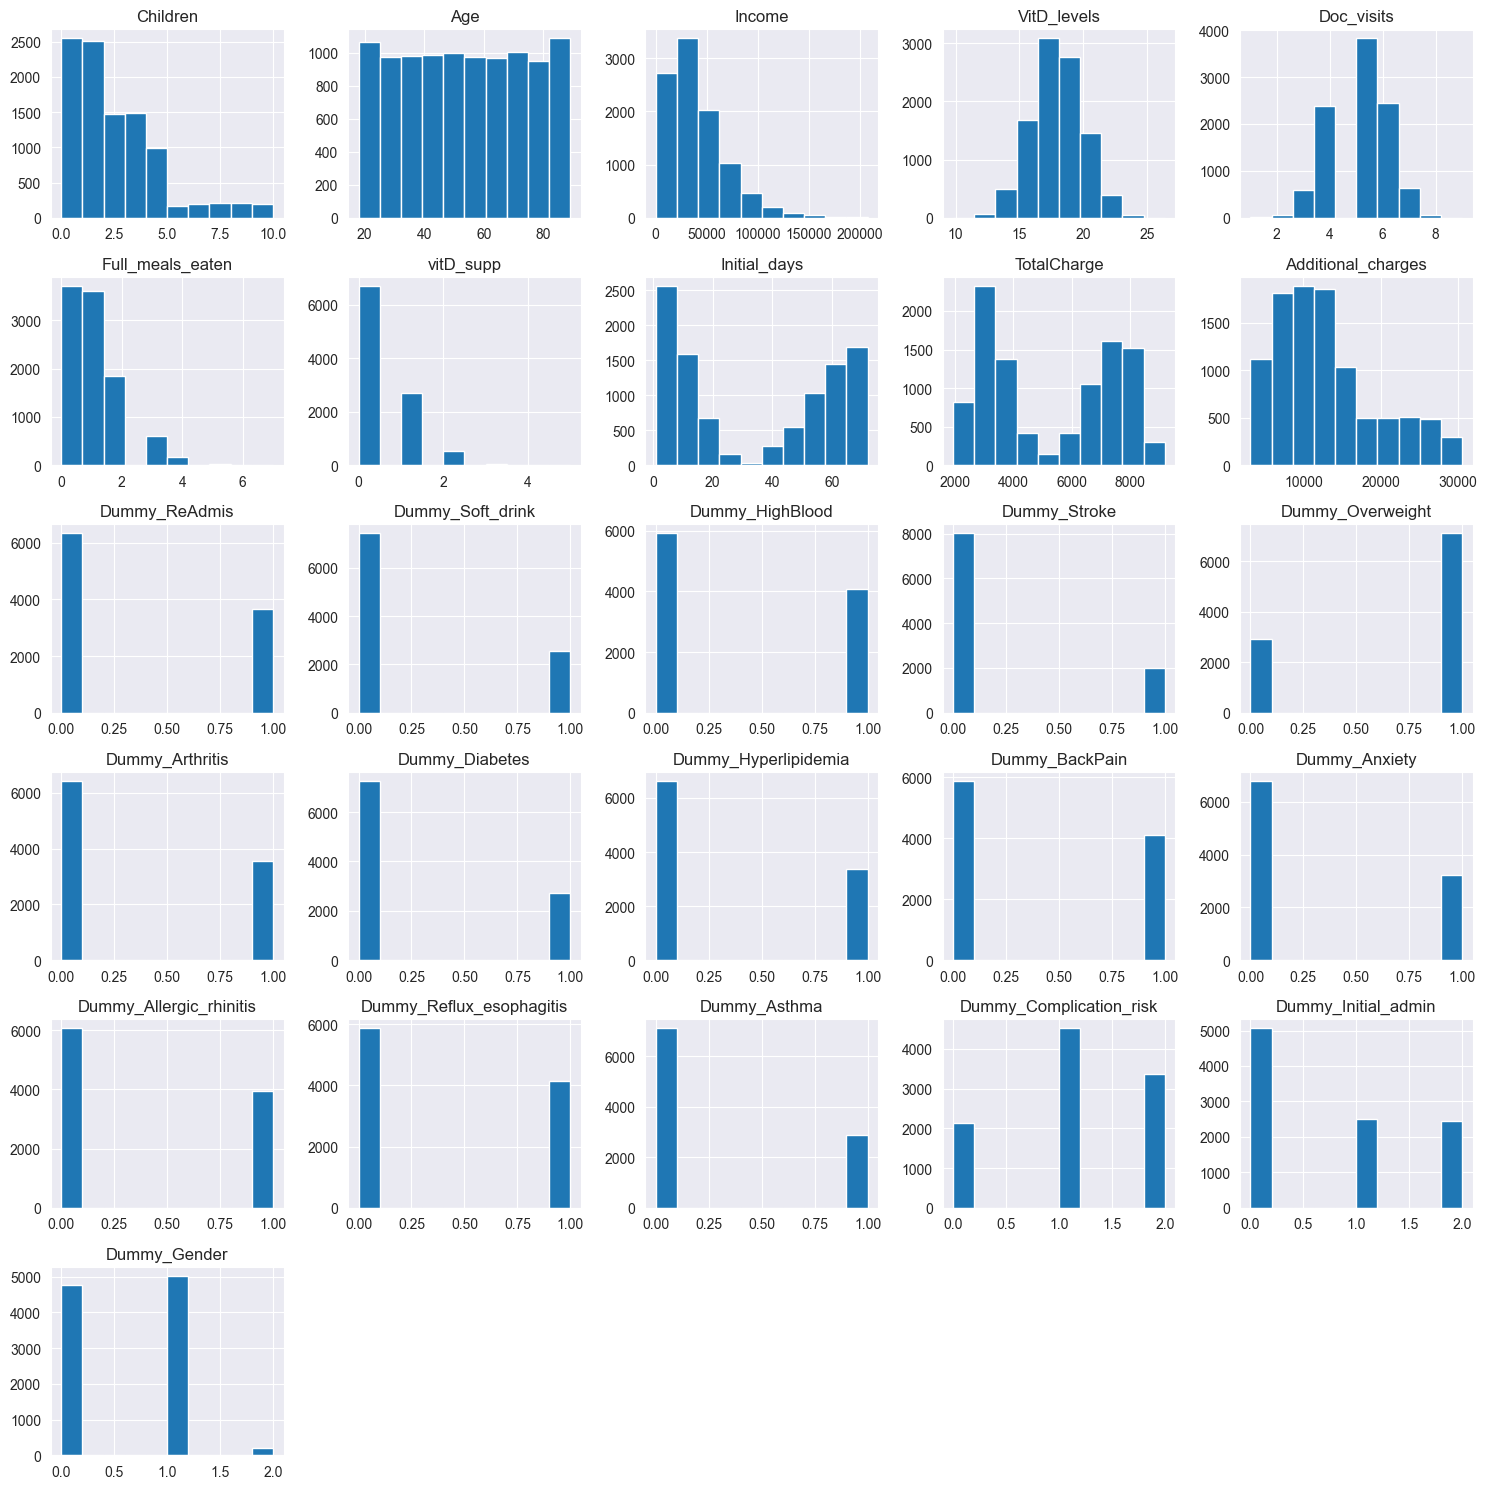

In [4]:
print('Univariate Numerical Variables')

prepared_medical_data.hist(figsize=(15, 15))
plt.savefig('univariate-histograms.jpg')
plt.tight_layout()

Bivariate Numerical Variables


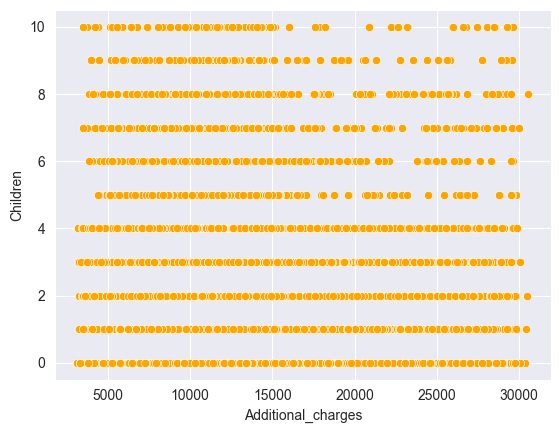

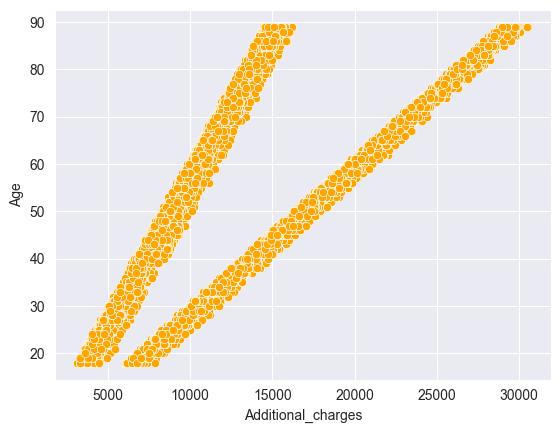

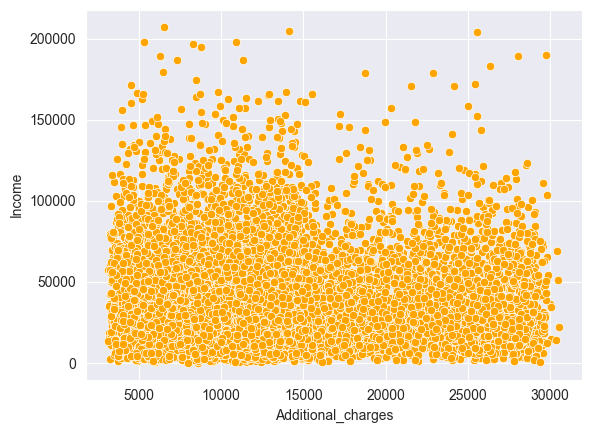

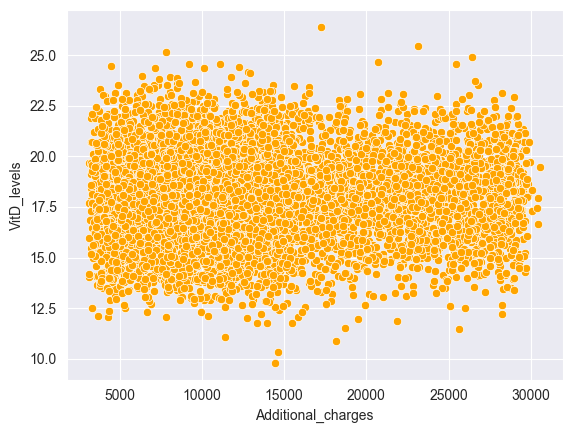

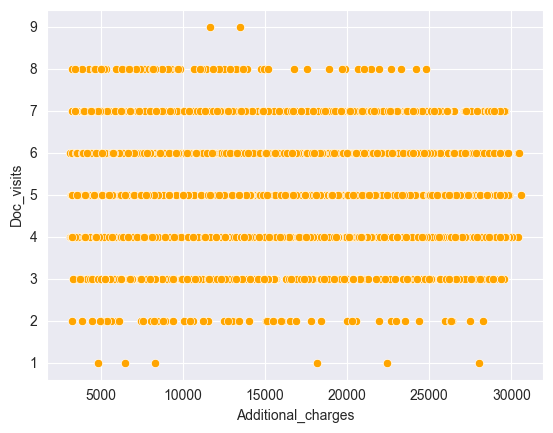

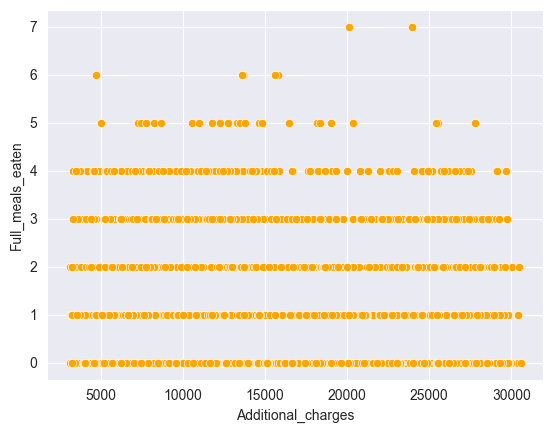

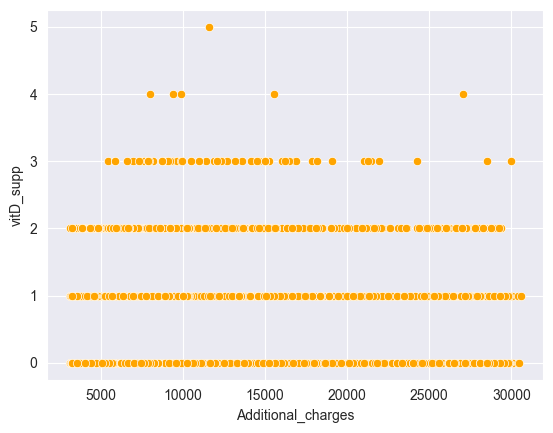

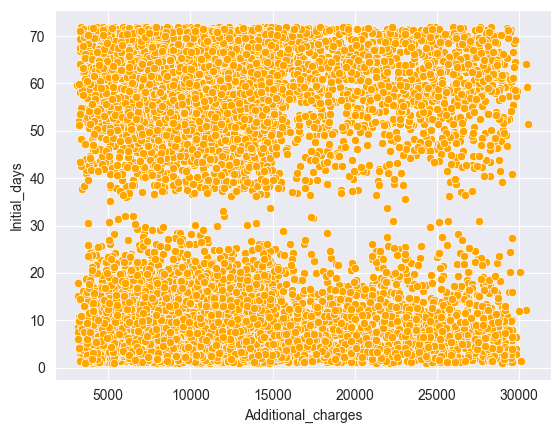

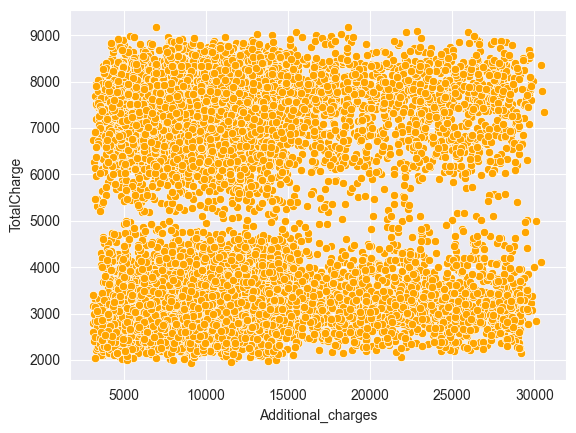

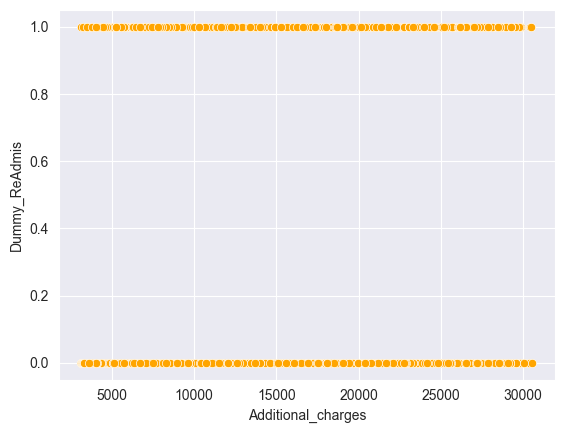

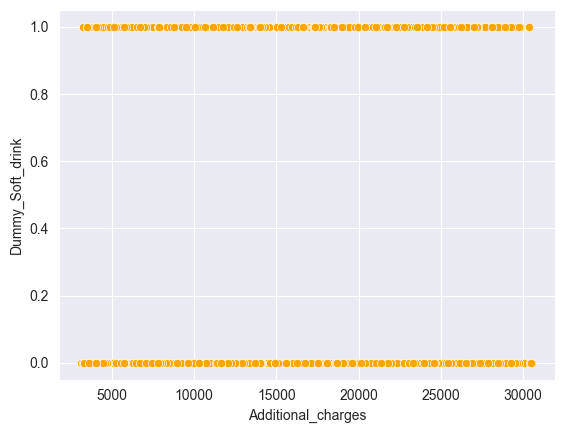

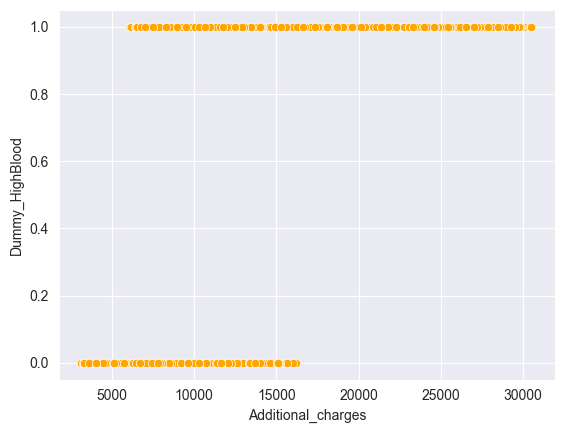

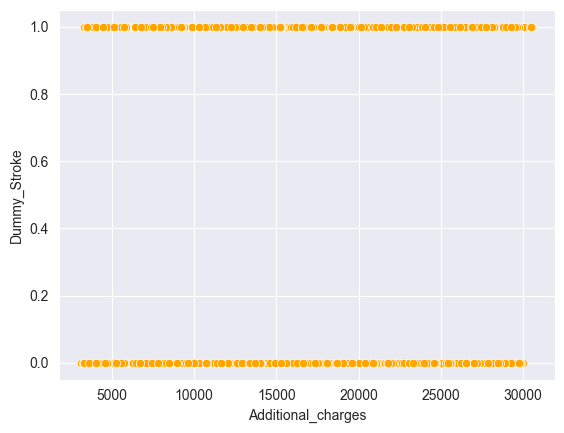

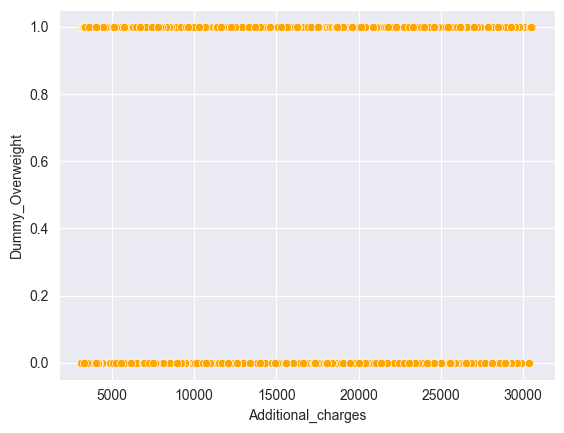

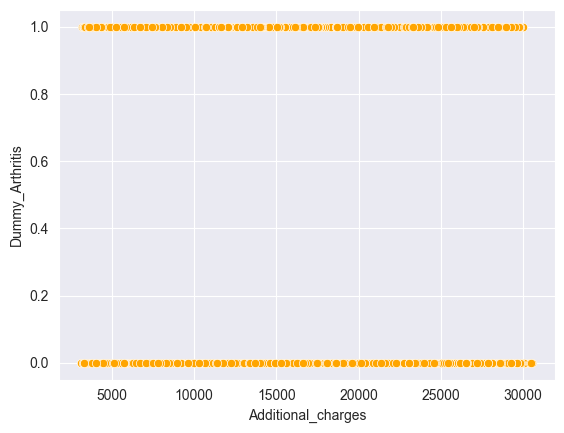

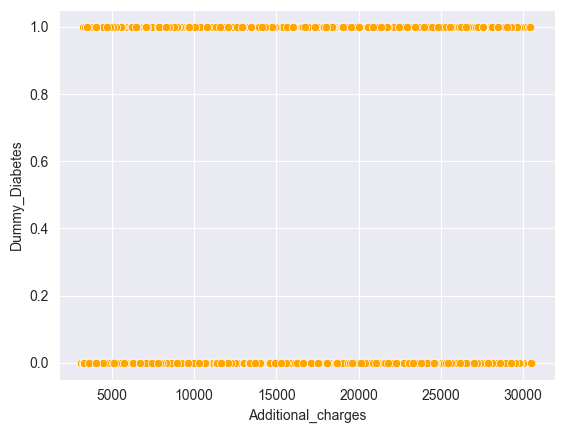

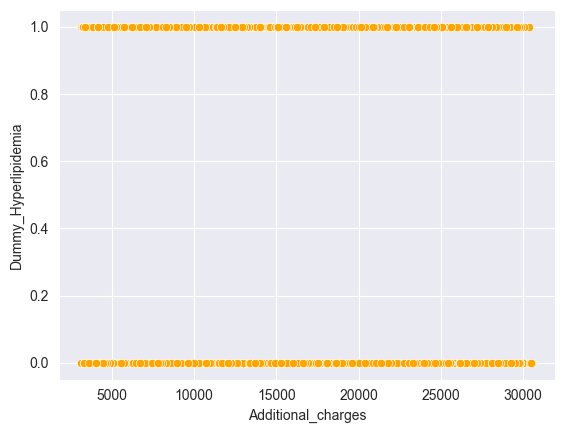

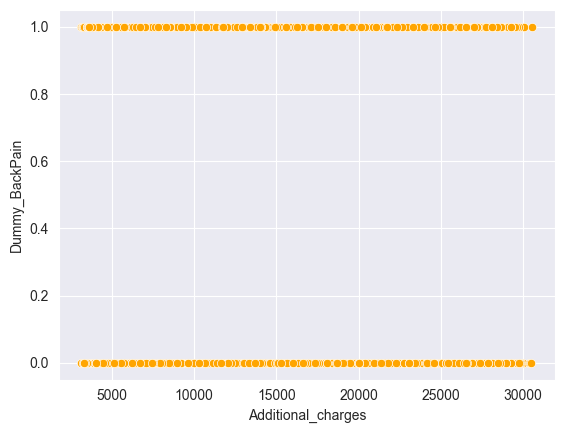

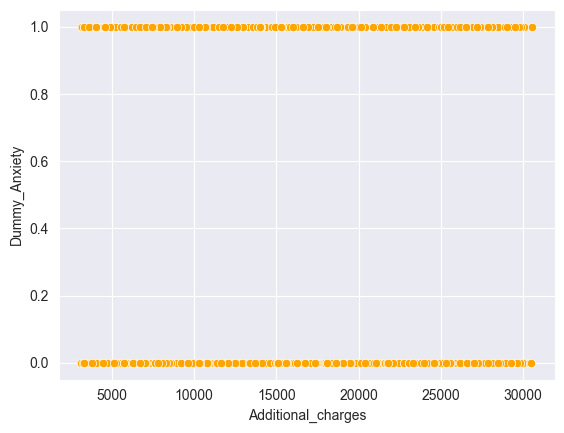

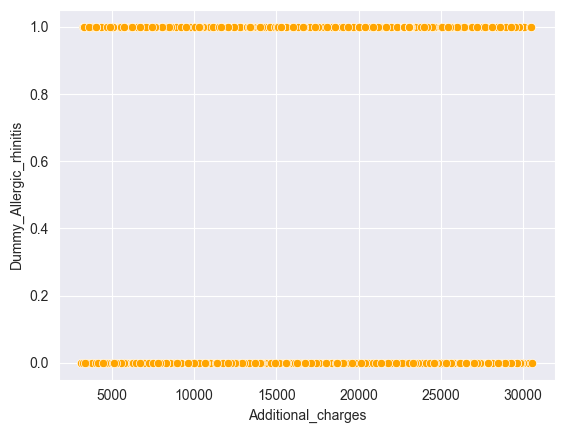

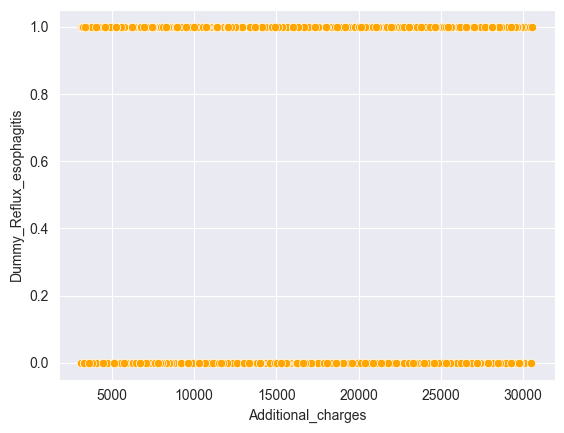

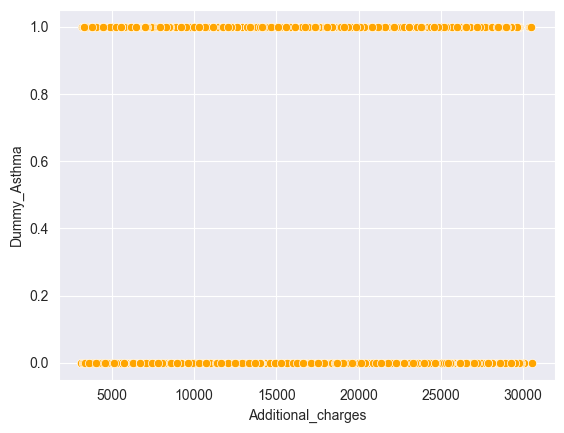

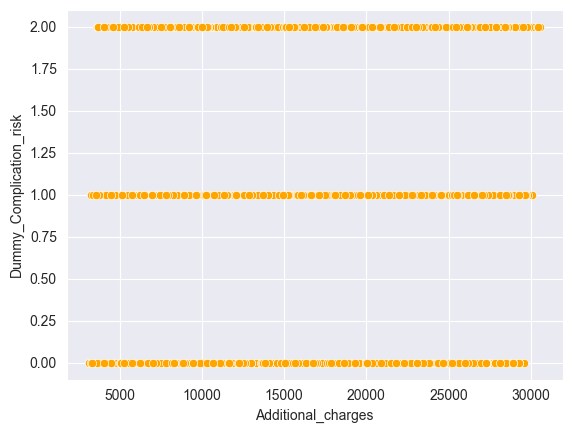

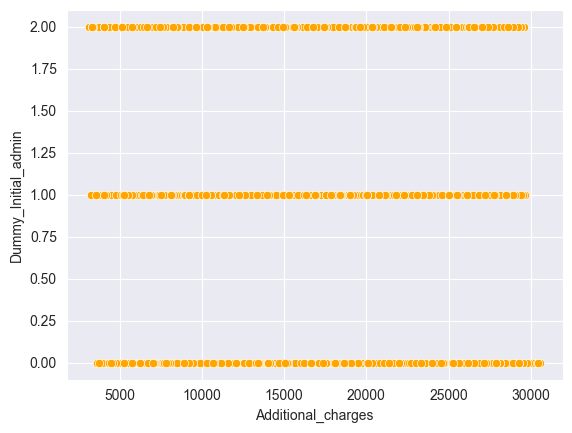

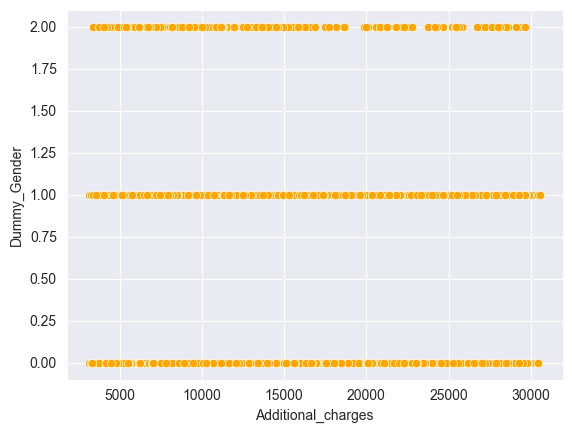

In [5]:
print('Bivariate Numerical Variables')

def chart_bivariate(independent: str, dependent: str, data: pd.DataFrame, color: str ='blue') -> None:
    sns.scatterplot(x=data[dependent], y=data[independent], color=color)
    #sns.scatterplot(x=data[independent], y=data[dependent], color=color)
    plt.show()

dependent_target = 'Additional_charges'
independent_variables = prepared_medical_data.drop(columns=dependent_target)

for indep in independent_variables.columns:
    chart_bivariate(indep, dependent_target, prepared_medical_data, 'orange')

# Prepared Dataset

In [6]:
#Get the original values back for the categorical columns before saving to csv
#prepared_medical = original_medical[medical_clean_data.columns]
prepared_medical_data.to_csv('./initial-medical-model-dataset.csv')

## Model Comparison and Analysis
#### Initial Linear Regression Model

In [7]:
#Initial formula is going to stick with the numerical values.
dependent_variable = prepared_medical_data['Additional_charges']
initial_explanatory_variables = prepared_medical_data.drop(columns='Additional_charges')

regression_model = LinearRegression()
regression_model.fit(initial_explanatory_variables, dependent_variable)

print(regression_model.coef_)
print(f'Intercept: {regression_model.intercept_}')


ols_fit = OLS(dependent_variable, initial_explanatory_variables).fit()

def generate_formula(intercept: int, dataset: pd.DataFrame, fit: RegressionResults) -> str:
    i = 0
    formula = f'y = {abs(intercept)}'
    for col in dataset.columns:
        formula += ' + {:.4f}*'.format(abs(fit.params[i])) + col
        i += 1
    return formula

initial_formula = generate_formula(regression_model.intercept_, initial_explanatory_variables, ols_fit)

print(initial_formula)
print(ols_fit.summary())


[ 1.40085064e+01  2.25774312e+02  1.22978657e-04 -1.24384992e+01
 -1.87610759e+01  1.34538671e+01 -7.70902186e+00 -5.86247562e+01
  6.88194399e-01  1.06714054e+02  2.56399841e+01  8.55358443e+03
  3.59976072e+02  3.74171751e+01 -1.05257227e+02  2.91974879e+00
 -5.82032686e+01 -8.92567597e+01 -2.88668486e+01 -4.55427427e+01
 -1.61761993e+01  5.40716610e+01  1.10566200e+02 -1.03139553e+02
 -1.38240411e+02]
Intercept: -4014.040979856516
y = 4014.040979856516 + 9.9515*Children + 224.3642*Age + 0.0005*Income + 63.2296*VitD_levels + 66.9367*Doc_visits + 6.2086*Full_meals_eaten + 22.5048*vitD_supp + 35.1320*Initial_days + 0.4705*TotalCharge + 146.1032*Dummy_ReAdmis + 9.6810*Dummy_Soft_drink + 8665.8292*Dummy_HighBlood + 345.9470*Dummy_Stroke + 5.3773*Dummy_Overweight + 42.8769*Dummy_Arthritis + 68.3028*Dummy_Diabetes + 26.6751*Dummy_Hyperlipidemia + 2.9351*Dummy_BackPain + 56.5823*Dummy_Anxiety + 4.3332*Dummy_Allergic_rhinitis + 28.1193*Dummy_Reflux_esophagitis + 35.7533*Dummy_Asthma + 348.35

## Model Comparison and Analysis
#### Reduced Linear Regression Model

In [8]:
#Initial formula is going to stick with the numerical values.
dependent_variable = prepared_medical_data['Additional_charges']
reduced_explanatory_variables = prepared_medical_data[['Age', 'VitD_levels', 'Doc_visits',
                                                       'Initial_days', 'TotalCharge', 'Dummy_HighBlood',
                                                       'Dummy_Stroke', 'Dummy_Complication_risk',
                                                       'Dummy_Initial_admin', 'Dummy_Gender']]

reduced_regression_model = LinearRegression()
reduced_regression_model.fit(reduced_explanatory_variables, dependent_variable)

print(reduced_regression_model.coef_)
print(reduced_regression_model.intercept_)

reduced_ols_fit = OLS(dependent_variable, reduced_explanatory_variables).fit()

reduced_formula = generate_formula(reduced_regression_model.intercept_, reduced_explanatory_variables, reduced_ols_fit)
print(reduced_formula)
print(reduced_ols_fit.summary())

[ 2.25725256e+02 -1.15827495e+01 -1.78395915e+01 -4.09007845e+01
  4.91454138e-01  8.57631259e+03  3.63548783e+02  1.57199739e+02
 -1.59960074e+02 -1.38071359e+02]
-3611.9323365399905
y = 3611.9323365399905 + 224.3247*Age + 65.3868*VitD_levels + 69.5676*Doc_visits + 34.4714*Initial_days + 0.4350*TotalCharge + 8662.0148*Dummy_HighBlood + 346.2801*Dummy_Stroke + 340.2887*Dummy_Complication_risk + 439.3655*Dummy_Initial_admin + 148.7851*Dummy_Gender
                                 OLS Regression Results                                
Dep. Variable:     Additional_charges   R-squared (uncentered):                   0.987
Model:                            OLS   Adj. R-squared (uncentered):              0.987
Method:                 Least Squares   F-statistic:                          7.740e+04
Date:                Fri, 24 Mar 2023   Prob (F-statistic):                        0.00
Time:                        14:37:09   Log-Likelihood:                         -88191.
No. Observations:    

# Reduced Model Residual Plots
#### Residuals are the differences between the predicted and actual values.

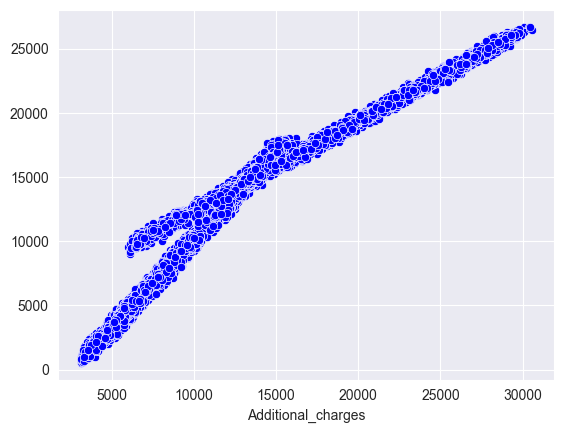

Residual Standard Error: 1636.1711939942945


In [9]:
residuals = reduced_ols_fit.predict(reduced_explanatory_variables)
sns.scatterplot(x=dependent_variable, y=residuals, color='blue')
plt.show()
print(f'Residual Standard Error: {np.std(reduced_ols_fit.resid)}')